In [1]:
import os, sys
import numpy as np
import EMdata

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools

In [3]:
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time
from numpy.random import multinomial

Matplotlib is building the font cache using fc-list. This may take a moment.


# Loading Data

In [4]:
#GPU or CPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
print(device)

cuda:0


In [5]:
#data path
file_path='/net/jiang/home/li3221/scratch/Xiaoqi/10230-tau/job063/run_it030_data.star'
datatype=0 #0 is relion 3.1, 1 is relion 3
df=True
block_size=66
file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [6]:
# parameters
#window size
#w = 4
#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44] #GSS20173_300
#ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46] 
#ignore_classes=[14] #10243_tau
#ignore_classes=[2,3,4,11,12,19,20,25,33,36,37,40,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig
#ignore_classes=[2,3,4,11,12,13,19,20,25,33,36,37,40,42,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig by observe
#ignore_classes=[2,5,6,7,12,16,19,23,24,25,30,31,32,33,39,44,45,50] #10340_Case2_tau_ig_E8
#ignore_classes=[]

In [7]:
%%time
if df:
    file_info=EMdata.read_data_df(file_path)
    dataframe=file_info.star2dataframe()
    metadata=dataframe.columns
    corpus_information=EMdata.process_helical_df(dataframe).extract_helical_select()
else:
    if datatype<2:
        file_info=EMdata.read_relion(file_path)
        if datatype==0:
            #read data (relion3.1)
            dataset=file_info.getRdata_31()
            optics=file_info.extractoptic()
        else:
            #read relion 3.0
            dataset=file_info.getRdata()
        metadata=dataset[0]
        print(metadata)
        data=dataset[1]
        print(data[0])
        #corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
        #label_path='F:/script/class2vec/real_star_file/self_unsupervised/10230_485_ctf/custom_single/pretext/'
        #label=np.load(label_path+'/classes_KM.npy')
        corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
corpus_dic,helix_name=corpus_information
corpus=list(corpus_dic.values())
print(corpus[0])
corpus_backup=corpus[:]

The filament number are:  7372
The number of particles are: 203269
0 0.8955105384190877 mins
10000 0.9139015595118205 mins
20000 0.9322466492652893 mins
30000 0.9507557829221089 mins
40000 0.9693374514579773 mins
50000 0.9879035949707031 mins
60000 1.006439952055613 mins
70000 1.025036625067393 mins
80000 1.0433624426523844 mins
90000 1.0616446256637573 mins
100000 1.0800374150276184 mins
110000 1.0985047936439514 mins
120000 1.1169509569803873 mins
130000 1.1349929292996725 mins
140000 1.153554864724477 mins
150000 1.1722139596939087 mins
160000 1.190627431869507 mins
170000 1.2089797854423523 mins
180000 1.2273686011632283 mins
190000 1.2457127571105957 mins
200000 1.2638571500778197 mins
finish converting
[(31,  1, 45) (81,  2, 46) ( 7,  4, 41) ( 7,  5, 42) ( 7,  6, 31)
 (58,  9,  9) (58, 10, 27) (58, 11, 28) (54, 12, 29) (54, 13,  0)
 (54, 14,  1) (54, 15,  2)]
[(31, 20, 49) (42, 21, 52) (12, 22, 53) (12, 23, 43) (12, 24, 44)
 (12, 25, 32) (90, 29, 10) (88, 33, 17) (98, 34, 18) (98

In [8]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    lst=corpus[i]
    count=lst[0][1]
    for j in range(len(lst)):
        particle=lst[j]
        if count==int(particle[1]):
            corpus_row.append(particle[0])
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(particle[0])
                    count+=1
                    break
                corpus_row+=[0]
                count+=1               
    corpus_ignore.append(corpus_row)

In [9]:
print(helix_name[0])
#corpus_ignore=corpus

('Extract/job060/DW_Micrographs/FoilHole_14817212_Data_14817538_14817539_20170415_1326-2613_cor2_DW.mrcs', 0)


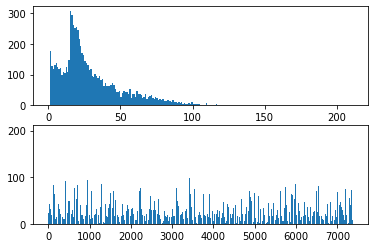

<Figure size 432x288 with 0 Axes>

In [10]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
fig,ax=plt.subplots(2)
ax[0].hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,1)))
ax[1].bar(list(range(0,len(corpus_backup))),corpus_length_histogram)
plt.show()
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"length_histogram.png",bbox_inches='tight', pad_inches=0.01)

# Pre-processing

In [11]:
#k-mer seperation
def overlaping_kmer(data,k):
    kmer_corpus=[]
    for i in range(len(data)):
        lst=data[i]
        kmer_lst=[]
        for j in range(len(lst)-k+1):
            kmer_lst.append(str(lst[j])+'-'+str(lst[j+1]))
        kmer_corpus.append(kmer_lst)
    return kmer_corpus

In [12]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [13]:
#corpus=overlaping_kmer(corpus_backup,2)
#corpus_context=corpus[:]

In [14]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

76


In [15]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [16]:
#corpus=cut_corpus(corpus_backup,60)
#corpus_context=corpus_backup[:]

In [17]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus_ignore))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [18]:
# convert to windoes vector
#w = 1
w = 20
context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus_ignore:
    for i, word in enumerate(text):
        if word==0:
            continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w+1, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            neighbor=text[j]
            if j==0:
                continue
            if neighbor==0:
                continue
            if i!=j:
                context_tuple_list.append((word, neighbor, next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 5331963 pairs of target and context words


# Word2vec

In [19]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [20]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [21]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [22]:
embedding_size=100
#loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters(),lr=1e-4)
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)
n=0
while True:
    n=n+1
    print(n)
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=1024)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)),torch.stack(losses)[0],torch.stack(losses)[-1])
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break
    if torch.mean(torch.stack(losses))<10:
        break

1
Loss:  tensor(6053.2808, device='cuda:0') tensor(13678.5566, device='cuda:0') tensor(2356.2900, device='cuda:0')
2
Loss:  tensor(1546.5145, device='cuda:0') tensor(2314.6997, device='cuda:0') tensor(1063.1689, device='cuda:0')
Loss gain: 74.45162963867188%
3
Loss:  tensor(957.6280, device='cuda:0') tensor(1136.9717, device='cuda:0') tensor(860.0601, device='cuda:0')
Loss gain: 84.18001556396484%
4
Loss:  tensor(835.4548, device='cuda:0') tensor(857.2729, device='cuda:0') tensor(852.9668, device='cuda:0')
Loss gain: 86.19831848144531%
5
Loss:  tensor(792.0052, device='cuda:0') tensor(792.6208, device='cuda:0') tensor(802.0426, device='cuda:0')
Loss gain: 86.91609191894531%
6
Loss:  tensor(770.0590, device='cuda:0') tensor(725.6769, device='cuda:0') tensor(737.3948, device='cuda:0')
Loss gain: 50.20680236816406%
7
Loss:  tensor(757.3181, device='cuda:0') tensor(801.7752, device='cuda:0') tensor(760.8691, device='cuda:0')
Loss gain: 20.91730308532715%
8
Loss:  tensor(749.1965, device='c

In [23]:
print(context_tuple_list[0])

(18, 28, [9, 62, 6, 10])


# Show 2D class embedding

In [24]:
import umap

In [25]:
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
from sklearn. manifold import MDS
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.metrics import pairwise_distances

EMBEDDINGS.shape:  (76, 100)
1
2
3
4
5


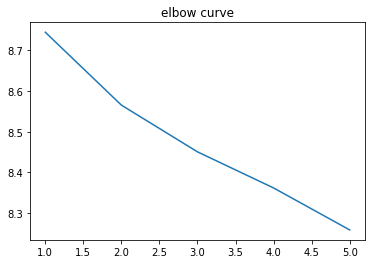

In [26]:
EMBEDDINGS = net.target.weight.data.cpu().numpy()
#EMBEDDINGS[word_to_index[0]]=np.zeros(embedding_size)
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

res = []
n_cluster = range(1,6)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

/net/jiang/home/li3221/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


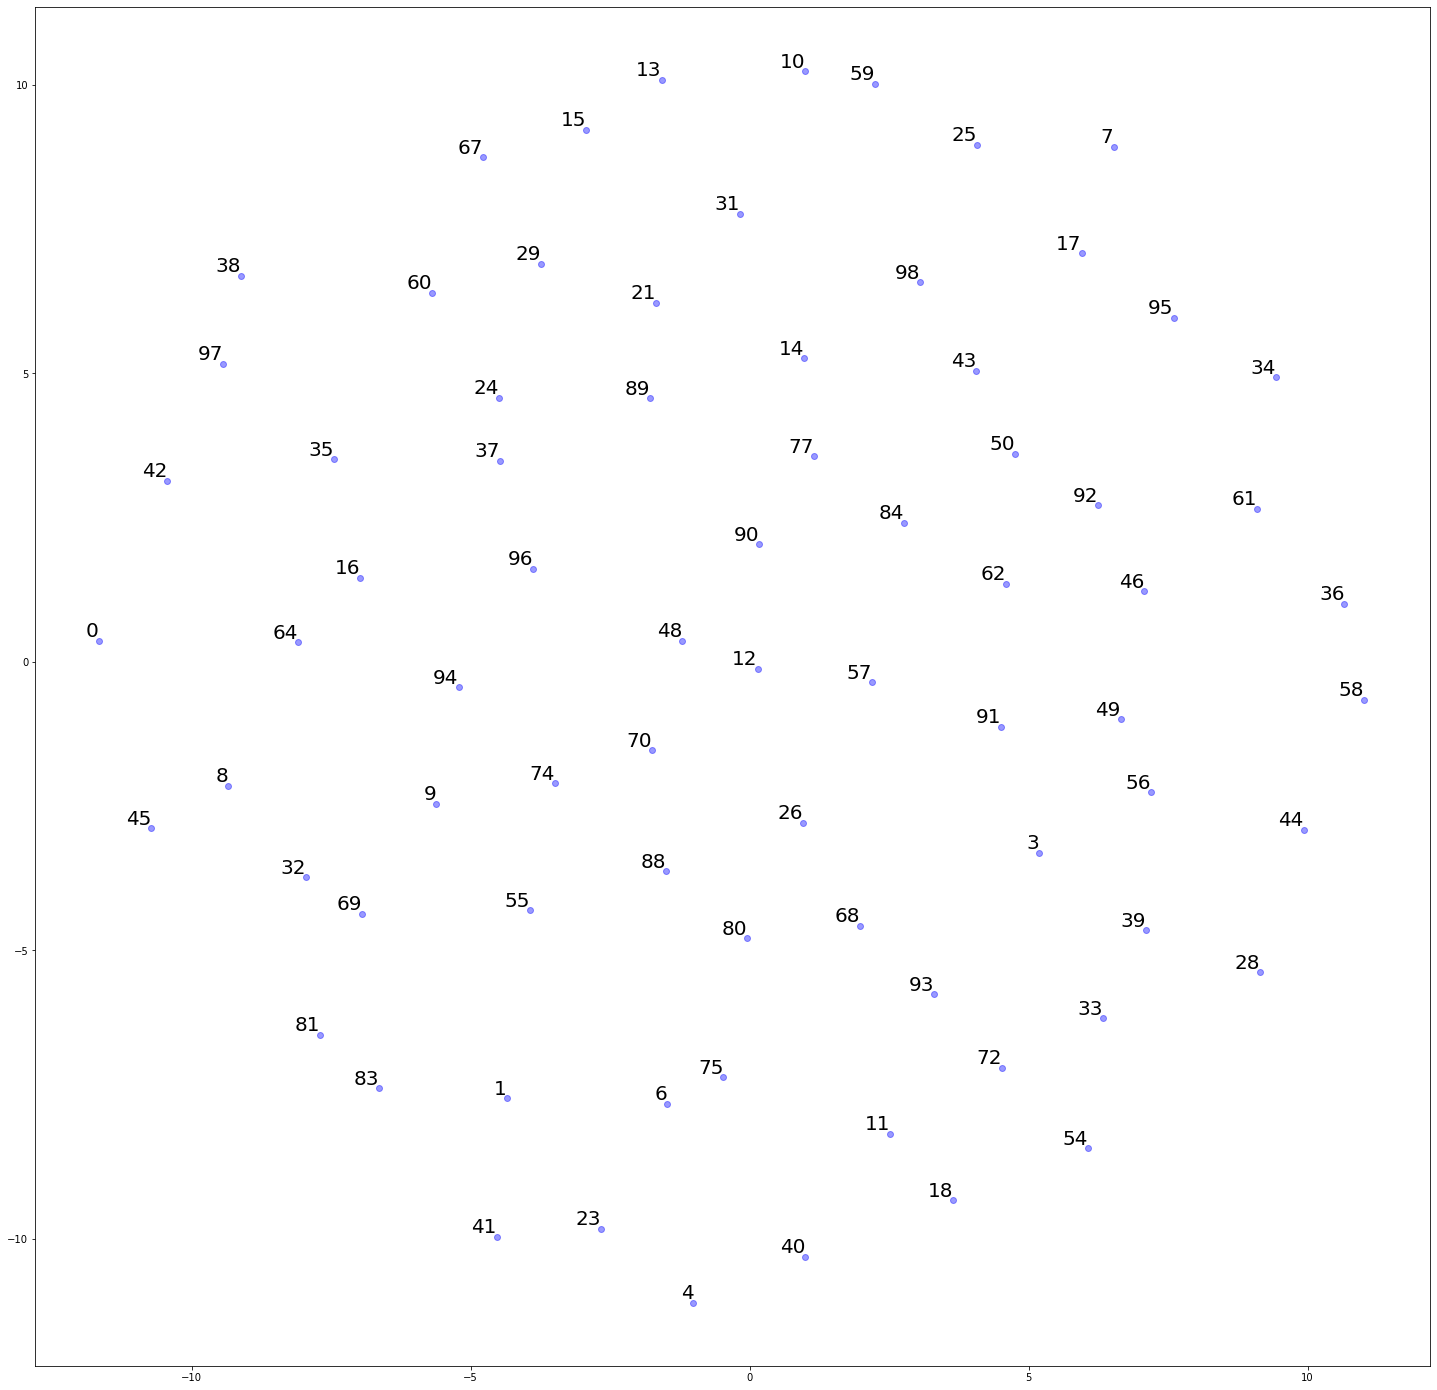

In [27]:
# see the 2D class segments embedding
class_PCA=PCA(n_components=2).fit_transform(EMBEDDINGS)
class_umap=umap.UMAP().fit_transform(EMBEDDINGS)
class_mds=MDS(n_components=2).fit_transform(EMBEDDINGS)
cluster_number=6
kmeans_best = SpectralClustering(n_clusters=cluster_number).fit_predict(class_PCA)
EMBEDDINGS_np=np.array(EMBEDDINGS)
plt.figure(figsize = (25,25))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(class_mds[i][0], class_mds[i][1],color='blue',alpha=0.4)
    plt.annotate(index_to_word[i], xy = (class_mds[i][0], class_mds[i][1]), \
        ha='right',va='bottom',fontsize=20)
plt.savefig(output_path+'/'+'w2v1_mds.png')
#color=plt.cm.RdYlBu(kmeans_best[i]/3)
plt.show()

In [28]:

#word_to_cluster={}
#for i in range(cluster_number):
#    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#print(word_to_cluster)

##using the histogram method to cluster 



#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

# Show Filament Embedding and cluster

In [29]:
# average filament embedding
from scipy import stats
filament_cluster_number=2
average_method=0 # 0 is average, 1 is weight average
filament_score=[]
all_filament_data=[]
filament_variance=[]
for filament in corpus_ignore:
    score=torch.zeros(embedding_size)
    counts=0
    filament_list=[]
    for i in filament:
        counts+=1
        filament_list.append(EMBEDDINGS[word_to_index[i]])
    if len(filament_list)==0:
        print('no')
    #if len(filament_list)==1:
    #    filament_variance.append(float(0))
    #else:
    #    pca=PCA(n_components=1).fit(filament_list)
    #    filament_variance.append(pca.singular_values_[0])
    filament_list=np.array(filament_list)
    mean=filament_list.mean(axis=0)
    if len(filament_list)==1:
        mean=filament_list[0]
    all_filament_data.append(filament_list)
    if average_method==0:
        filament_score.append(mean)
    elif average_method==1:
        dim=len(filament_list[0])
        filament_normalized=np.exp(-0.5*((filament_list-mean) @ (filament_list-mean).T*0)).diagonal()/np.sqrt(np.pi**dim*0.05)
        filament_normalized=filament_normalized/filament_normalized.sum()
        score=filament_normalized @ filament_list
        if counts<=2:
            continue
        filament_score.append(np.array(score))
all_data=filament_score[:]
all_data.extend(EMBEDDINGS_np)
all_data_np=np.array(filament_score[:])
filament_number=len(filament_score)
print(filament_number)
#filament_normalized=np.exp(-0.5*((filament_list-mean) @ (filament_list-mean).T)).diagonal()/np.sqrt(np.pi**dim)

7372


In [30]:
with open(output_path+'/'+'filament_vectors.npy', 'wb') as f:
    np.save(f, all_data)

In [ ]:
pca_sum = PCA(n_components=2).fit_transform(all_data)
print('finish 2D')
pca_sum_3D = PCA(n_components=3).fit_transform(all_data)
print('finish 3D')
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])
#label=[0]*10+[1]*14
plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:filament_number,0], pca_sum[:filament_number,1],c='blue')
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(pca_sum[i+filament_number][0], pca_sum[i+filament_number][1],color='black',marker='*')
    plt.annotate(index_to_word[i], xy = (pca_sum[i+filament_number][0], pca_sum[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

## Umap of the filament embedding

In [31]:
%%time
n_neighbors=100
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(all_data)

CPU times: user 2min 58s, sys: 557 ms, total: 2min 58s
Wall time: 21.5 s


In [32]:
umap_3D = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=3).fit_transform(all_data)
filament_umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=50).fit_transform(all_data)[0:filament_number]
filament_umap=umap_2D[0:filament_number]
filament_umap_3D=umap_3D[0:filament_number]

2
3
4
5
6
7
8
9
10


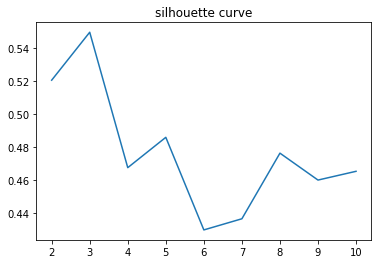

In [33]:
res=[]
n_cluster = range(2,11)
for i in n_cluster:
    print(i)
    kmeans_model = KMeans(n_clusters=i).fit(filament_umap_3D)
    labels = kmeans_model.labels_
    a=metrics.silhouette_score(filament_umap, labels, metric='euclidean')
    res.append(a)

plt.plot(n_cluster, res)
plt.title('silhouette curve')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_silhouette.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


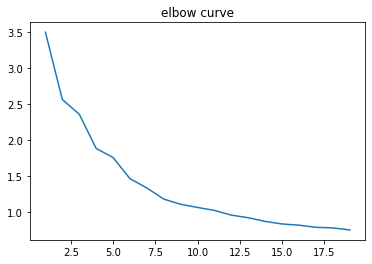

In [34]:
res = []
n_cluster = range(1,20)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(filament_umap_3D)
    res.append(np.average(np.min(cdist(filament_umap_3D, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

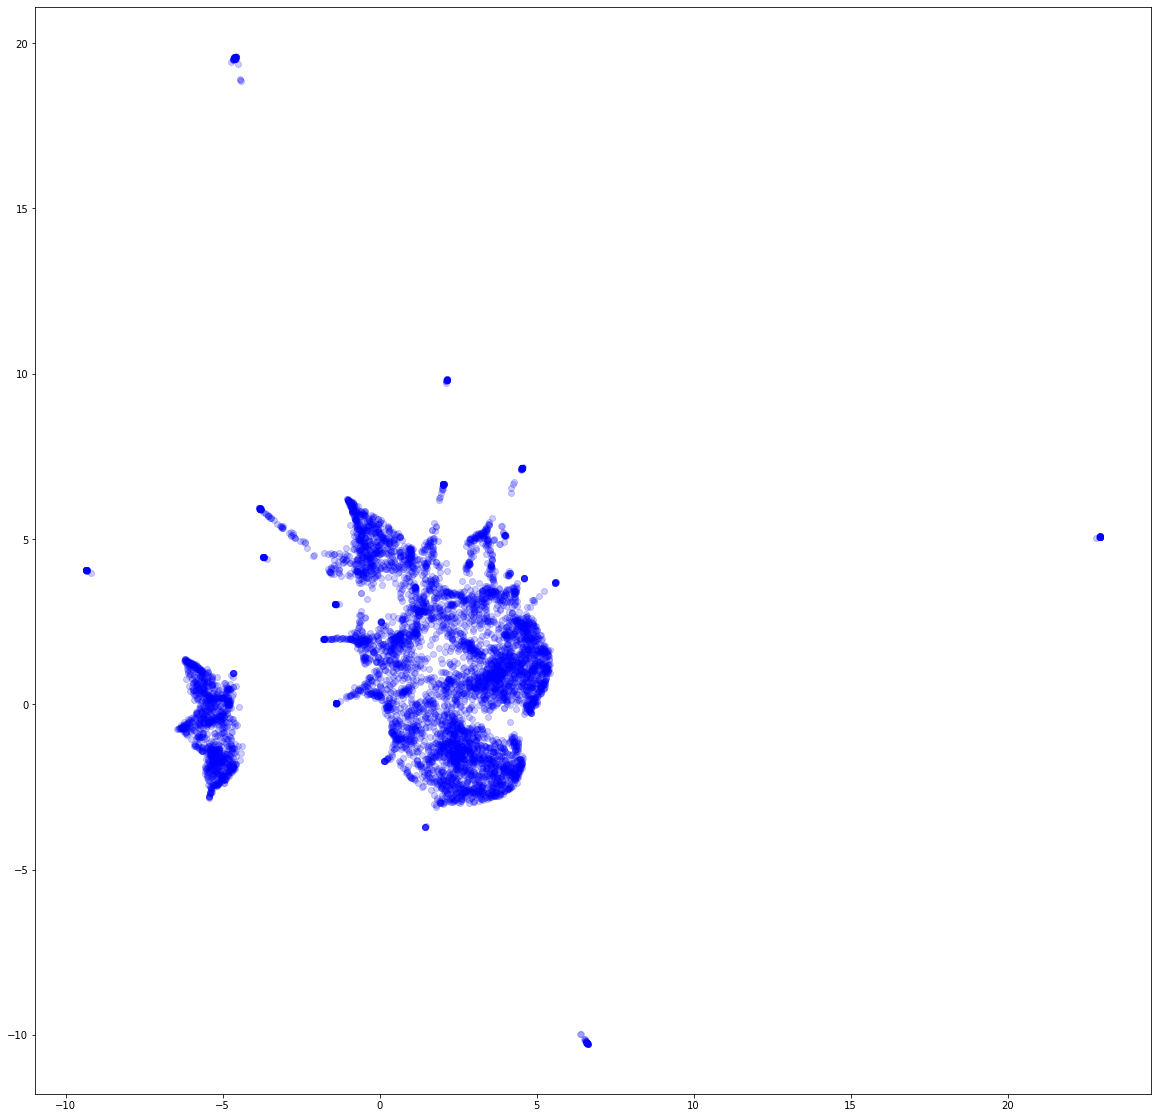

In [35]:
plt.figure(figsize = (20, 20))
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.2,c='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue.png",bbox_inches='tight', pad_inches=0.01)
#plt.xlim((6,14))
#plt.ylim((-5,15))
plt.show()

In [36]:
with open(output_path+'/'+'umap_3D_normal.npy', 'wb') as f:
    np.save(f, filament_umap_3D)
with open(output_path+'/'+'umap_2D.npy', 'wb') as f:
    np.save(f, filament_umap)
print('finish umap')

finish umap


In [37]:
#filament_cluster_number=12
#umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(filament_umap_ND)
#np.save(output_path+'/'+'umap_cluster.npy',umap_predict)
#umap_predict=SpectralClustering(n_clusters=filament_cluster_number).fit_predict(filament_umap)
umap_predict=DBSCAN(eps=1.4, min_samples=300).fit_predict(filament_umap)+1
filament_cluster_number=len(np.unique(umap_predict))
#np.save(output_path+'/'+'umap_predict.npy',umap_predict)

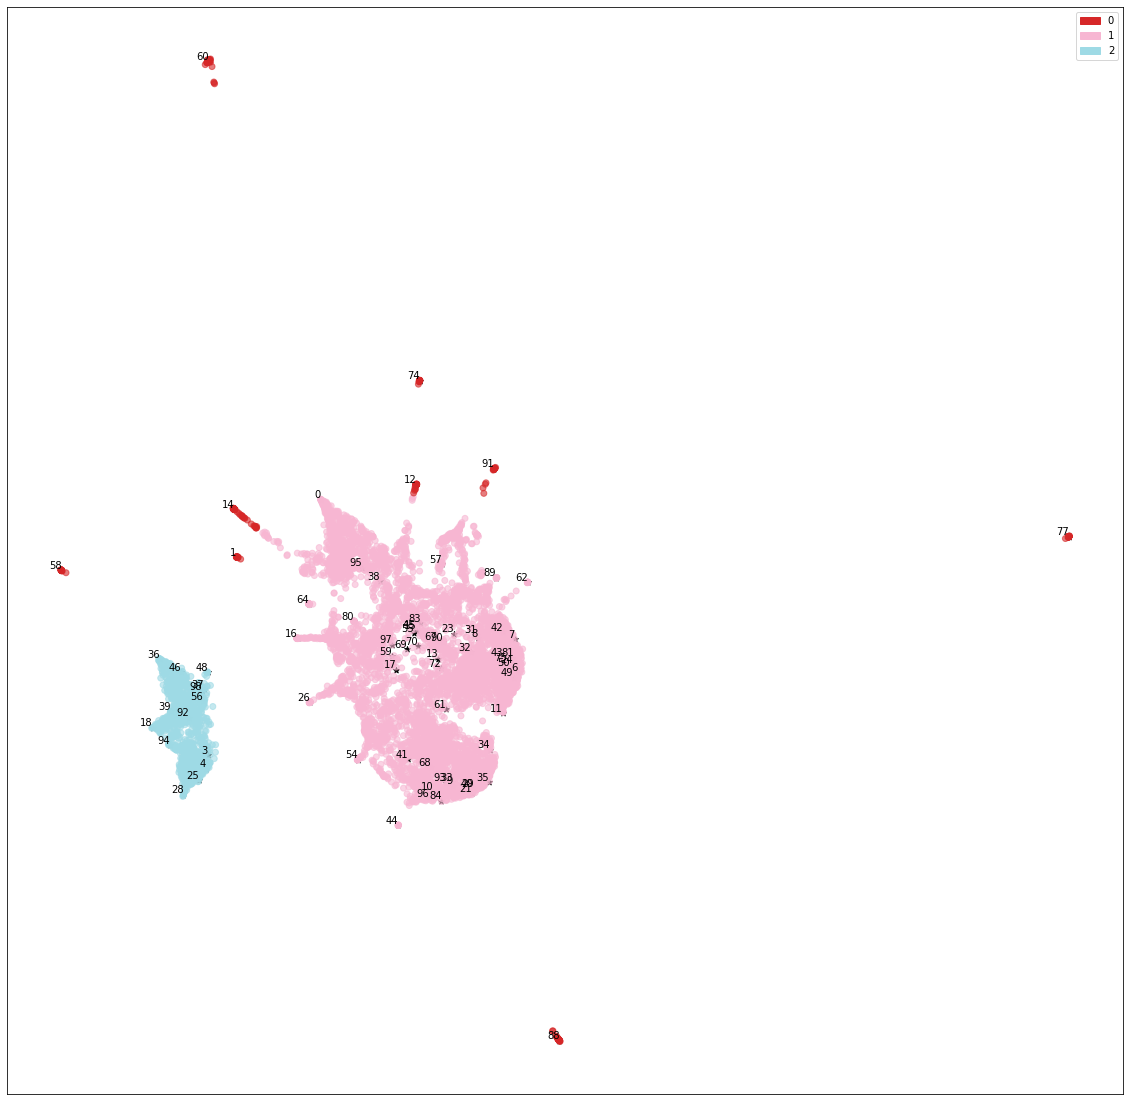

In [38]:
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), label=str(i))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
plt.tick_params(axis='both',which='both',bottom=False, left=False,labelbottom=False,labelleft=False) 
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*')
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
#plt.xlim((-5,18))
#plt.ylim((-5,15))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
#color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

In [39]:
#max_c=max(filament_variance)
#filament_variance=np.array(filament_variance)
#alpha=filament_variance/max_c
#alpha_threshold=np.array([0 if a_ <0.1 else a_ for a_ in alpha])
#rgba_colors = np.zeros((len(filament_variance),4))
#rgba_colors[:,2]=1
#rgba_colors[:,3]=alpha_threshold
#plt.figure(figsize = (20, 20))
#plt.scatter(filament_umap[:,0], filament_umap[:,1],color=rgba_colors)
#for i in range(len(EMBEDDINGS_np)):
#    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*',s=50)
#    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
##plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue_threshold.pdf",bbox_inches='tight', pad_inches=0.01)
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue_threshold.png",bbox_inches='tight', pad_inches=0.01)
#plt.show()

# color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)
# color='blue'

In [40]:
def select_area(all_filament_data,all_data_array,filament_index,start,length):
    select_filament_area=all_filament_data[filament_index][start:start+length]
    select_area_mean=select_filament_area.mean(axis=0)
    distance=np.sqrt(np.sum((all_data_array-select_area_mean)**2,axis=1))
    i=np.argmin(distance)
    return i, distance
similar_list=[]
filament_index=11
print(corpus_ignore[filament_index])
for i in range(0,len(all_filament_data[filament_index]),12):
    a, distance=select_area(all_filament_data,filament_score,filament_index,i,7)
    similar_list.append(a)
print(similar_list)

[8, 16, 32, 32, 32, 32, 7, 7, 7, 35, 35, 62, 62, 62, 62, 62, 89, 89, 89, 89, 88, 88]
[5398, 708]


## Seperate the clusters

In [41]:
print(helix_name[0][0].split('/'))
print(helix_name[0][0][27:])

['Extract', 'job060', 'DW_Micrographs', 'FoilHole_14817212_Data_14817538_14817539_20170415_1326-2613_cor2_DW.mrcs']
hs/FoilHole_14817212_Data_14817538_14817539_20170415_1326-2613_cor2_DW.mrcs


In [42]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
start_index=11
cluster_choice=umap_predict
positive_label=[]
for i in range(len(helix_name)):
    positive_label.append(helix_name[i][0][start_index:start_index+3])
    #simulate experiment
    #positive_label.append(helix_name[i][63:68])
    #positive_label.append(helix_name[i].split('-')[-2][-10:])
    #cryosparc
    #positive_label.append(helix_name[i][0][84:87])
positive_label=np.array(positive_label)
labels=list(np.unique(positive_label))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
#labels_name=['type 3','type 1B','type 2B','type 1A','type 2A','type 2AB'] # define the type of filaments 
#labels_name=['singlet','doublet']
labels_name=['jagged','snake','twister']
#labels_name=['PHF','SF']
#labels_name=['SF','PHF']
#labels_name=['1','2','3','4','5']
clustersize=[]
for i in range(filament_cluster_number):
    clustersize.append(len(locals()['cluster'+str(i)]))
print(labels)
print(clustersize)

['060']
[0, 0, 0]


# Compare with the positive labels

7372 7372
7372


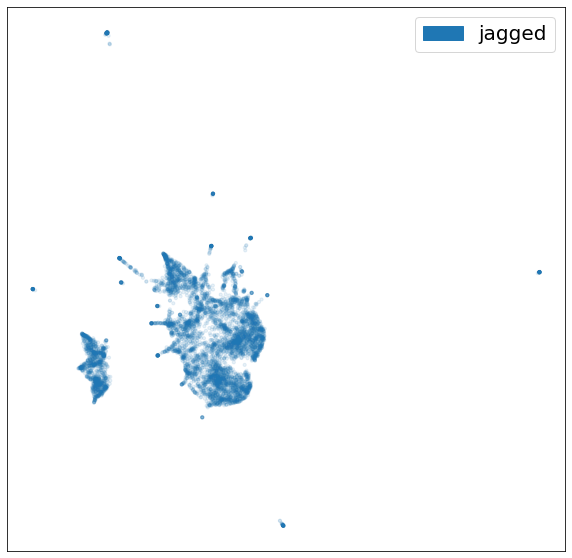

In [43]:
print(len(positive_label_new),len(filament_umap))
plt.figure(figsize = (10, 10))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/3), label=labels_name[i])
plt.tick_params(axis='both',which='both',bottom=False, left=False,labelbottom=False,labelleft=False) 
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))],fontsize=20)
print(len(positive_label))
#1/3-
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=plt.cm.tab20(positive_label_new/3),alpha=0.1,s=10)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_label.pdf",bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_label.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

355 0
5854 1
1163 2
[[1.0], [1.0], [1.0]]


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,)  and requested shape (1,)

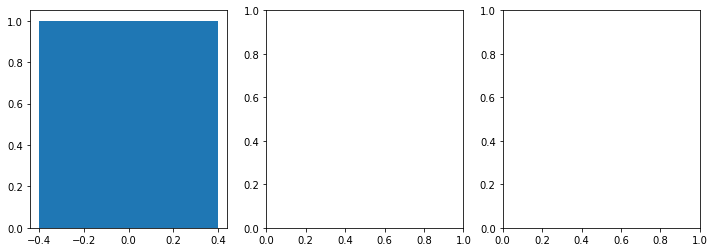

In [44]:
# histogram on rate of successful
import pandas as pd
hist_data=pd.DataFrame({'labels':positive_label_new,'predict':cluster_choice})
distribution_hist_all=[]
particle_number=[]
for i in range(filament_cluster_number):
    distribution=[]
    lst=hist_data[hist_data['predict']==i]
    particle_number.append(len(lst))
    print(len(lst),i)
    for j in range(len(labels)):
        distribution.append(len(lst[lst['labels']==j])/len(lst))
    distribution_hist_all.append(distribution)
print(distribution_hist_all)
np.save(output_path+'/''class_distribution.npy',distribution_hist_all)
np.save(output_path+'/''particle_number.npy',particle_number)
fig, ax = plt.subplots(1,filament_cluster_number,figsize = (4*filament_cluster_number,4))

for i in range(filament_cluster_number):
    ax[i].bar(range(len(labels)),distribution_hist_all[i],tick_label =labels_name)
    ax[i].set_ylim(bottom=0, top=1)
    ax[i].set_xticklabels(labels_name, fontsize=15, fontname='Arial')
    ax[i].set_title('cluster {}'.format(i),fontsize=30, fontname='Arial')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.pdf',bbox_inches='tight', pad_inches=0.1)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
#print(len(positive_label_new),len(filament_umap))
#ori_type1=np.load('F:/script/class2vec/real_star_file/simulation/NoNoise_random/type1_filament_polarity.npy')
#ori_type2=np.load('F:/script/class2vec/real_star_file/simulation/NoNoise_random/type2_filament_polarity.npy')
#polarity_label=[0,180]
#polarity=np.append(ori_type1,ori_type2)
#print(polarity)
#plt.figure(figsize = (10, 10))
#for i in range(len(polarity_label)):
#    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/2), label='phi='+str(polarity_label[i]))
#plt.tick_params(axis='both',which='both',bottom=False, left=False,labelbottom=False,labelleft=False) 
#plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(polarity_label))],fontsize=40)
#print(len(polarity_label))
#plt.scatter(filament_umap[:,0], filament_umap[:,1],color=plt.cm.tab20(polarity/360),s=100)
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_ori.pdf",bbox_inches='tight', pad_inches=0.01)
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_ori.png",bbox_inches='tight', pad_inches=0.01)
#plt.show()

In [45]:
#seperate cluster
if df:
    dataframe_out=dataframe.drop(columns=['pid','filename','class','helicaltube','phi0'])
    metadata=list(dataframe_out.columns)
    metadata=['_'+name for name in metadata]
    data=dataframe_out.values
    optics=EMdata.read_relion(file_path).extractoptic()
for i in range(filament_cluster_number):
    locals()['cluster'+str(i)]=[]
    locals()['clusterID'+str(i)]=[]
for i in range(len(corpus)):
    labels=umap_predict[i]
    locals()['clusterID'+str(labels)].append(i)
    lst=corpus[i]
    for j in range(len(lst)):
        dataline=lst[j][-1]
        locals()['cluster'+str(labels)].append(data[dataline])

In [46]:
optics

[[],
 ['#', 'version', '30001'],
 [],
 ['data_optics'],
 [],
 ['loop_'],
 ['_rlnOpticsGroupName', '#1'],
 ['_rlnOpticsGroup', '#2'],
 ['_rlnMicrographOriginalPixelSize', '#3'],
 ['_rlnVoltage', '#4'],
 ['_rlnSphericalAberration', '#5'],
 ['_rlnAmplitudeContrast', '#6'],
 ['_rlnImagePixelSize', '#7'],
 ['_rlnImageSize', '#8'],
 ['_rlnImageDimensionality', '#9'],
 ['opticsGroup1',
  '1',
  '1.150000',
  '300.000000',
  '2.700000',
  '0.100000',
  '5.750000',
  '128',
  '2'],
 [],
 [],
 ['#', 'version', '30001']]

In [47]:
print(optics)

[[], ['#', 'version', '30001'], [], ['data_optics'], [], ['loop_'], ['_rlnOpticsGroupName', '#1'], ['_rlnOpticsGroup', '#2'], ['_rlnMicrographOriginalPixelSize', '#3'], ['_rlnVoltage', '#4'], ['_rlnSphericalAberration', '#5'], ['_rlnAmplitudeContrast', '#6'], ['_rlnImagePixelSize', '#7'], ['_rlnImageSize', '#8'], ['_rlnImageDimensionality', '#9'], ['opticsGroup1', '1', '1.150000', '300.000000', '2.700000', '0.100000', '5.750000', '128', '2'], [], [], ['#', 'version', '30001']]


In [ ]:
#seperarte subcluster
for i in range(filament_cluster_number):
    cluster=locals()['cluster'+str(i)]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        subcluster_name='cluster'+str(i)+'_'+str(j)
        locals()[subcluster_name]=[x for x, y in zip(cluster,lst) if y==labels[j]]

In [ ]:
print(helix_name[0])

# Write .star file for the clusters

In [48]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
# write subcluster relion
for i in range(filament_cluster_number):
    for j in range(filament_cluster_number):
        cluster_name='cluster'+str(i)+'_'+str(j)
        data_cluster=locals()[cluster_name]
        if datatype==0:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.opticgroup(optics)
            output.writecluster()
        elif datatype==1:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.writemetadata()
            output.writecluster()